<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [ ]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/image_capt


Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/image_capt


### Data preprocessing

In [26]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 373 ms, sys: 953 ms, total: 1.33 s
Wall time: 25.6 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [27]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [28]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


In [29]:
for i in range(len(captions[0])):
    print(" ".join(captions[0][i]))

#START# people shopping in an open market for vegetables . #END#
#START# an open market full of people and piles of vegetables . #END#
#START# people are shopping at an open air produce market . #END#
#START# large piles of carrots and potatoes at a crowded outdoor market . #END#
#START# people shop for vegetables like carrots and potatoes at an open air market . #END#


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [65]:
# Build a Vocabulary
from collections import Counter
import tqdm

word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for image in tqdm.tqdm(captions):
    for caption in image:
        word_counts += Counter(caption)

100%|██████████| 118287/118287 [27:32<00:00, 71.59it/s]


In [66]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [67]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i, seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [68]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [69]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [70]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=512, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE>
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, num_layers = 2, batch_first=True) # <YOUR CODE>
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) # <YOUR CODE>
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, 
                                (torch.cat((initial_hid[None], initial_hid[None]), dim=0),
                                 torch.cat((initial_cell[None], initial_cell[None]), dim=0)))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [71]:
network = CaptionNet(n_tokens)

In [72]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [73]:
from torch.autograd import Variable

def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data.cpu() if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [90]:
# criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    log_probs = F.log_softmax(logits_for_next, dim=-1)
    crossentropy = - torch.sum(log_probs * to_one_hot(captions_ix_next, n_tokens), dim = -1)
    
    mask = (captions_ix_next != pad_ix).type(torch.FloatTensor)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)
    
    return loss

In [91]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [92]:
opt = torch.optim.AdamW(network.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5)

# Training

* First implement the batch generator
* Than train the network as usual

In [93]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [94]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [95]:
generate_batch(img_codes,captions,3)

(tensor([[0.3556, 0.4498, 1.1789,  ..., 0.3548, 0.2563, 0.8156],
         [0.1492, 0.1322, 0.3220,  ..., 0.0920, 0.2522, 0.5616],
         [0.1005, 0.4355, 0.3238,  ..., 0.3642, 0.2303, 0.0695]]),
 tensor([[   1,   24,  429,   58, 1694,  123,  428,  123,   15, 1473,   35,   24,
            47,  291,   12,    2],
         [   1,   24,  139,   41,   38,  107,   24,  473,  174,   24,   84,   55,
            12,    2,    3,    3],
         [   1,   88,  267,   58, 1532,   85,   45, 1432,   35,   24,  307,   12,
             2,    3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [96]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [97]:
from tqdm import tqdm

best_loss = None
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    if best_loss is None or best_loss > val_loss:
        best_loss = val_loss
        torch.save(network.state_dict(), 'network.pt')
    scheduler.step(val_loss)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Epoch: 0, train loss: 5.984682168960571, val loss: 5.077074909210205


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Epoch: 1, train loss: 4.849783697128296, val loss: 4.6954926490783695


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]



Epoch: 2, train loss: 4.627242183685302, val loss: 4.450308799743652


100%|██████████| 50/50 [00:35<00:00,  1.43it/s]



Epoch: 3, train loss: 4.427272253036499, val loss: 4.239245319366455


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]



Epoch: 4, train loss: 4.203914070129395, val loss: 4.132748985290528


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Epoch: 5, train loss: 4.052619090080261, val loss: 3.9958287715911864


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 6, train loss: 3.886149263381958, val loss: 3.8781755924224854


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Epoch: 7, train loss: 3.800542850494385, val loss: 3.8153022289276124


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Epoch: 8, train loss: 3.7236489772796633, val loss: 3.7508137226104736


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]



Epoch: 9, train loss: 3.645264759063721, val loss: 3.7562825202941896


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Epoch: 10, train loss: 3.583958582878113, val loss: 3.447117471694946


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 11, train loss: 3.5186377716064454, val loss: 3.4779311180114747


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]



Epoch: 12, train loss: 3.4733289003372194, val loss: 3.4628488063812255


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 13, train loss: 3.4260261964797976, val loss: 3.3002583503723146


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]



Epoch: 14, train loss: 3.3572346687316896, val loss: 3.4056396484375


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 15, train loss: 3.2873937845230103, val loss: 3.451388645172119


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Epoch: 16, train loss: 3.3473961544036865, val loss: 3.317693519592285


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]



Epoch: 17, train loss: 3.2408095693588255, val loss: 3.4045312881469725


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]



Epoch: 18, train loss: 3.2245668363571167, val loss: 3.2014241218566895


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]



Epoch: 19, train loss: 3.234366273880005, val loss: 3.2931725025177


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 20, train loss: 3.1929134130477905, val loss: 3.1795026302337646


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]



Epoch: 21, train loss: 3.1762232971191406, val loss: 3.2111612796783446


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 22, train loss: 3.1221238946914673, val loss: 3.1567986965179444


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 23, train loss: 3.095272283554077, val loss: 2.9966859817504883


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



Epoch: 24, train loss: 3.090944185256958, val loss: 3.1887142181396486


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



Epoch: 25, train loss: 3.079143409729004, val loss: 3.1872345924377443


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 26, train loss: 3.045178184509277, val loss: 3.1592336177825926


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]



Epoch: 27, train loss: 3.068808746337891, val loss: 2.9569061279296873


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]



Epoch: 28, train loss: 3.0300741243362426, val loss: 3.1315965175628664


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 29, train loss: 3.0372115087509157, val loss: 2.970717716217041


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 30, train loss: 3.015215444564819, val loss: 3.047209596633911


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 31, train loss: 2.965866379737854, val loss: 3.0031256675720215


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]



Epoch: 32, train loss: 3.0020865297317503, val loss: 2.969155740737915


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]



Epoch: 33, train loss: 2.9591197395324706, val loss: 3.058486986160278


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]



Epoch: 34, train loss: 2.954854369163513, val loss: 2.8015402793884276


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]



Epoch: 35, train loss: 2.923704295158386, val loss: 2.957266998291016


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Epoch: 36, train loss: 2.9420192289352416, val loss: 2.991454076766968


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]



Epoch: 37, train loss: 2.952843885421753, val loss: 2.935712289810181


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]



Epoch: 38, train loss: 2.88976891040802, val loss: 2.9010589599609373


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]



Epoch: 39, train loss: 2.9209192895889284, val loss: 3.026595401763916


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]



Epoch: 40, train loss: 2.8671805238723755, val loss: 2.8978407859802244


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]



Epoch: 41, train loss: 2.862663507461548, val loss: 2.901581144332886


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]



Epoch: 42, train loss: 2.845199546813965, val loss: 2.8916038990020754


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]



Epoch: 43, train loss: 2.8588266563415528, val loss: 2.7169957160949707


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]



Epoch: 44, train loss: 2.8681841897964477, val loss: 2.9452115058898927


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]



Epoch: 45, train loss: 2.848198471069336, val loss: 2.746052646636963


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]



Epoch: 46, train loss: 2.851276035308838, val loss: 2.7787713050842284


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]



Epoch: 47, train loss: 2.832991986274719, val loss: 2.8720746517181395


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



Epoch: 48, train loss: 2.8128255462646483, val loss: 2.8296547889709474


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 49, train loss: 2.804310450553894, val loss: 2.8143919944763183


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Epoch: 50, train loss: 2.8137281560897827, val loss: 2.8205546855926515


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 51, train loss: 2.8049591541290284, val loss: 2.817241144180298


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]



Epoch: 52, train loss: 2.7798558378219607, val loss: 2.7667006492614745


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]



Epoch: 53, train loss: 2.829508843421936, val loss: 2.6888070583343504


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]



Epoch: 54, train loss: 2.753906216621399, val loss: 2.7742690086364745


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



Epoch: 55, train loss: 2.7654304790496824, val loss: 2.8625781536102295


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]



Epoch: 56, train loss: 2.7598355913162234, val loss: 2.80530161857605


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]



Epoch: 57, train loss: 2.788357696533203, val loss: 2.7622260093688964


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]



Epoch: 58, train loss: 2.722478246688843, val loss: 2.733673429489136


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]



Epoch: 59, train loss: 2.759285807609558, val loss: 2.780017042160034


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]



Epoch: 60, train loss: 2.7201146364212034, val loss: 2.805848503112793


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]



Epoch: 61, train loss: 2.7305324029922486, val loss: 2.7788881778717043


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 62, train loss: 2.758922619819641, val loss: 2.624064588546753


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]



Epoch: 63, train loss: 2.7535541915893553, val loss: 2.8111362934112547


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]



Epoch: 64, train loss: 2.709713077545166, val loss: 2.8381703376770018


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



Epoch: 65, train loss: 2.73415020942688, val loss: 2.7106081008911134


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Epoch: 66, train loss: 2.706481943130493, val loss: 2.8907259941101073


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]



Epoch: 67, train loss: 2.752694664001465, val loss: 2.6791661262512205


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]



Epoch: 68, train loss: 2.7279437589645386, val loss: 2.741559362411499


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]



Epoch: 69, train loss: 2.6886808586120607, val loss: 2.781453323364258


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]



Epoch: 70, train loss: 2.66498206615448, val loss: 2.871627855300903


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



Epoch: 71, train loss: 2.6868969202041626, val loss: 2.7360222816467283


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]



Epoch: 72, train loss: 2.697070379257202, val loss: 2.6330614566802977


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Epoch: 73, train loss: 2.7042410802841186, val loss: 2.73364520072937


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]



Epoch: 74, train loss: 2.666193790435791, val loss: 2.6585773468017577


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



Epoch: 75, train loss: 2.6882944917678833, val loss: 2.701059103012085


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]



Epoch: 76, train loss: 2.6994364404678346, val loss: 2.61977276802063


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]



Epoch: 77, train loss: 2.64979887008667, val loss: 2.7109532833099363


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]



Epoch: 78, train loss: 2.66330894947052, val loss: 2.7570157051086426


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



Epoch: 79, train loss: 2.6447135496139524, val loss: 2.6687433242797853


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]



Epoch: 80, train loss: 2.6494744491577147, val loss: 2.729761838912964


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



Epoch: 81, train loss: 2.6402315711975097, val loss: 2.8438655376434325


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]



Epoch: 82, train loss: 2.681184239387512, val loss: 2.7809916973114013


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]



Epoch: 83, train loss: 2.6596109867095947, val loss: 2.7214112758636473


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]



Epoch: 84, train loss: 2.6370094871520995, val loss: 2.668624210357666


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]



Epoch: 85, train loss: 2.6122499084472657, val loss: 2.6438186168670654


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]



Epoch: 86, train loss: 2.621173095703125, val loss: 2.7960382461547852


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Epoch: 87, train loss: 2.633618211746216, val loss: 2.716499614715576


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]



Epoch: 88, train loss: 2.6271199655532835, val loss: 2.6924909591674804


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]



Epoch: 89, train loss: 2.6265173244476316, val loss: 2.715499019622803


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]



Epoch: 90, train loss: 2.615553689002991, val loss: 2.6286487102508547


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]



Epoch: 91, train loss: 2.5849785375595093, val loss: 2.6297213077545165


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



Epoch: 92, train loss: 2.620207681655884, val loss: 2.64691219329834


100%|██████████| 50/50 [00:39<00:00,  1.25it/s]



Epoch: 93, train loss: 2.560379424095154, val loss: 2.6138118743896483


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



Epoch: 94, train loss: 2.618976993560791, val loss: 2.524241018295288


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



Epoch: 95, train loss: 2.587474799156189, val loss: 2.715761661529541


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



Epoch: 96, train loss: 2.62443594455719, val loss: 2.6659383296966555


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



Epoch: 97, train loss: 2.596994524002075, val loss: 2.7093660831451416


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]



Epoch: 98, train loss: 2.6070630502700807, val loss: 2.7367600440979003


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]



Epoch: 99, train loss: 2.619772186279297, val loss: 2.605687713623047
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [100]:
network = CaptionNet(n_tokens)
network.load_state_dict(torch.load('network.pt'))

<All keys matched successfully>

In [99]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [101]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [102]:
!mkdir img_data

In [103]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img_data/img.jpg

--2022-06-19 18:31:21--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-06-19 18:31:21--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2022-06-19 18:31:23 (4.25 MB/s) - ‘img_data/img

In [105]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img_data/img.jpg
img = plt.imread('img_data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2022-06-19 18:31:37--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-06-19 18:31:37--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2022-06-19 18:31:37 (3.80 MB/s) - ‘img_data/img

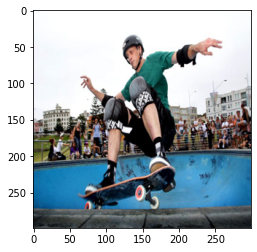

In [106]:
plt.imshow(img)

In [107]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man on a skateboard doing tricks on a skateboard .
a man is doing a trick on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man is doing a trick on a skateboard .
a man doing a trick on a skateboard .
a man on a skateboard doing a trick on a skateboard .


--2022-06-19 18:32:01--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-06-19 18:32:01--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 104.37K   276KB/s    in 0.4s    

2022-06-19 18:32:02 (276 KB/s) - ‘img_data/img.jpg’ saved [106870/106870]



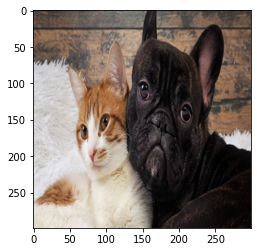

a cat sitting on top of a white blanket .
a dog is sitting on a bed with a cat
a dog is sitting on a wooden floor .
a black and white cat sitting on a bench .
a cat is sitting on a bed with a cat
a dog is sitting on a wooden floor .
a dog is sitting on a wooden floor .
a cat is sitting on a bench in a room .
a dog sitting on a bed with a cat
a dog sitting on a bed with a cat on it .


In [108]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img_data/img.jpg
img = plt.imread('img_data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [112]:
urls = [
    "https://thumbs.dreamstime.com/b/man-standing-alone-field-4646345.jpg",
    'https://res.cloudinary.com/twenty20/private_images/t_standard-fit/photosp/076d44e1-b1fc-4f59-834a-39f35fa2ca7f/stock-photo-animal-portrait-cat-kitten-mammal-bench-ears-urban-fluffy-076d44e1-b1fc-4f59-834a-39f35fa2ca7f.jpg',
    "https://horoshieprivychki.ru/wp-content/uploads/2020/01/chto-polezno-est-na-zavtrak-muzhchine-e1580286789307.jpg",
    "https://iso.500px.com/wp-content/uploads/2016/11/stock-photo-159533631-1500x1000.jpg",
    "https://static.vl.ru/news/1633676821958_default",
    "https://www.crushpixel.com/big-static14/preview4/airplane-flying-away-sky-view-1737647.jpg",
    "https://cdn.thedailymash.co.uk/wp-content/uploads/20190324205638/random667.jpg",
    "https://tarusa.yahonty.ru/upload/iblock/a5c/a5cf7ce6fe2163289eaf8fee2355f1b0.jpg",
    "https://cdn7.dissolve.com/p/D943_94_311/D943_94_311_1200.jpg",
    "https://img.freepik.com/free-photo/a-giraffe-group-eats-the-leaves-of-the-acacia-trees_258981-631.jpg",
    "https://image.shutterstock.com/image-photo/cow-standing-lake-drinking-water-260nw-110403227.jpg"
    
]

--2022-06-19 18:46:08--  https://thumbs.dreamstime.com/b/man-standing-alone-field-4646345.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.144.114
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.144.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57723 (56K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  56.37K  --.-KB/s    in 0.01s   

2022-06-19 18:46:08 (4.20 MB/s) - ‘img_data/img.jpg’ saved [57723/57723]



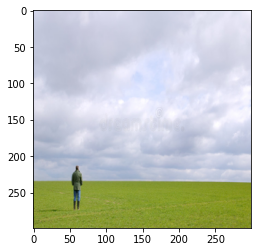

a man standing on a field with a kite .
a man is flying a kite in the air .
a man is standing on a field with a kite .
a man in a field flying a kite .
a man and a woman are playing frisbee in a field .
a man in a field flying a kite .
a man is flying a kite on a beach .
--2022-06-19 18:46:12--  https://res.cloudinary.com/twenty20/private_images/t_standard-fit/photosp/076d44e1-b1fc-4f59-834a-39f35fa2ca7f/stock-photo-animal-portrait-cat-kitten-mammal-bench-ears-urban-fluffy-076d44e1-b1fc-4f59-834a-39f35fa2ca7f.jpg
Resolving res.cloudinary.com (res.cloudinary.com)... 184.85.108.42, 2600:1417:76:493::523, 2600:1417:76:495::523
Connecting to res.cloudinary.com (res.cloudinary.com)|184.85.108.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75509 (74K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  73.74K  --.-KB/s    in 0.006s  

2022-06-19 18:46:12 (11.5 MB/s) - ‘img_data/img.jpg’ saved [75509/75509]



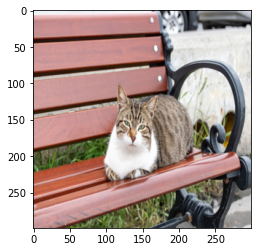

a cat sitting on a bench in a park .
a cat sitting on a bench in a park .
a cat sitting on top of a wooden bench .
a cat sitting on a bench in a park .
a cat sitting on a bench in a park .
a cat sitting on a bench in the grass .
a cat sitting on top of a wooden bench .
--2022-06-19 18:46:16--  https://horoshieprivychki.ru/wp-content/uploads/2020/01/chto-polezno-est-na-zavtrak-muzhchine-e1580286789307.jpg
Resolving horoshieprivychki.ru (horoshieprivychki.ru)... 87.236.16.185
Connecting to horoshieprivychki.ru (horoshieprivychki.ru)|87.236.16.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39366 (38K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  38.44K  --.-KB/s    in 0.001s  

2022-06-19 18:46:18 (45.9 MB/s) - ‘img_data/img.jpg’ saved [39366/39366]



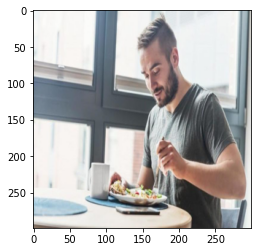

a man sitting at a table with a plate of food .
a man sitting at a table with a plate of food .
a man is sitting on a table with a plate of food .
a man sitting at a table with a plate of food .
a man sitting at a table with a plate of food .
a man sitting at a table with a plate of food .
a man sitting at a table with a plate of food .
--2022-06-19 18:46:22--  https://iso.500px.com/wp-content/uploads/2016/11/stock-photo-159533631-1500x1000.jpg
Resolving iso.500px.com (iso.500px.com)... 13.225.103.44, 13.225.103.48, 13.225.103.17, ...
Connecting to iso.500px.com (iso.500px.com)|13.225.103.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129801 (127K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 126.76K  --.-KB/s    in 0.03s   

2022-06-19 18:46:22 (4.33 MB/s) - ‘img_data/img.jpg’ saved [129801/129801]



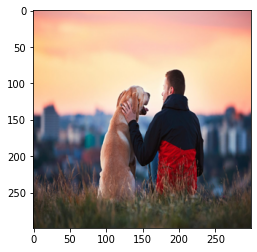

a man in a black jacket and a black dog .
a man in a black jacket and a black jacket and a black dog
a man with a dog standing on a field with a frisbee .
a man with a dog is standing on a field .
a man is sitting on a bench with a dog .
a man with a dog standing in the grass .
a man with a dog standing in the grass .
--2022-06-19 18:46:26--  https://static.vl.ru/news/1633676821958_default
Resolving static.vl.ru (static.vl.ru)... 80.92.164.33, 80.92.164.32
Connecting to static.vl.ru (static.vl.ru)|80.92.164.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1169070 (1.1M) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]   1.11M   573KB/s    in 2.0s    

2022-06-19 18:46:30 (573 KB/s) - ‘img_data/img.jpg’ saved [1169070/1169070]



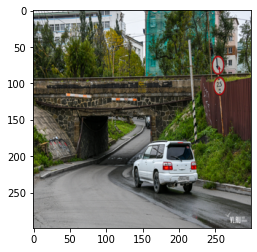

a train is on the tracks near a train station .
a train is on the tracks next to a building .
a train on a track with a train on it
a train is on the tracks near a train station .
a train on a track with a train on it
a train is on the tracks near a building .
a train on a track in a parking lot .
--2022-06-19 18:46:34--  https://www.crushpixel.com/big-static14/preview4/airplane-flying-away-sky-view-1737647.jpg
Resolving www.crushpixel.com (www.crushpixel.com)... 104.26.3.53, 104.26.2.53, 172.67.69.6, ...
Connecting to www.crushpixel.com (www.crushpixel.com)|104.26.3.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146690 (143K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 143.25K  --.-KB/s    in 0.04s   

2022-06-19 18:46:34 (3.96 MB/s) - ‘img_data/img.jpg’ saved [146690/146690]



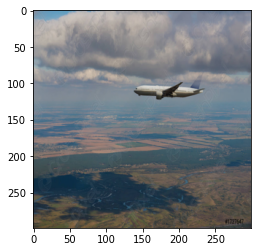

a plane is flying in the air with a blue sky .
a plane flying in the air with a cloudy sky .
a plane flying over a field with a blue sky .
a plane flying in the air with a blue sky .
a plane flying in the air with a blue sky .
a plane is flying over a blue sky .
a large plane flying in the air with a blue sky .
--2022-06-19 18:46:38--  https://cdn.thedailymash.co.uk/wp-content/uploads/20190324205638/random667.jpg
Resolving cdn.thedailymash.co.uk (cdn.thedailymash.co.uk)... 104.18.18.13, 104.18.19.13, 2606:4700::6812:130d, ...
Connecting to cdn.thedailymash.co.uk (cdn.thedailymash.co.uk)|104.18.18.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174450 (170K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 170.36K  --.-KB/s    in 0.009s  

2022-06-19 18:46:38 (17.9 MB/s) - ‘img_data/img.jpg’ saved [174450/174450]



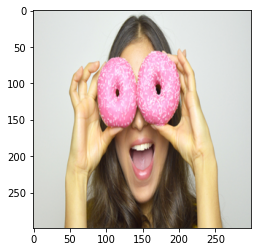

a man is holding a hot dog with a banana .
a person holding a hot dog with a banana .
a person holding a hot dog with a banana .
a person holding a banana in a box .
a person holding a banana in a box .
a person holding a banana in a box .
a person holding a hot dog with a banana .
--2022-06-19 18:46:41--  https://tarusa.yahonty.ru/upload/iblock/a5c/a5cf7ce6fe2163289eaf8fee2355f1b0.jpg
Resolving tarusa.yahonty.ru (tarusa.yahonty.ru)... 188.120.228.12
Connecting to tarusa.yahonty.ru (tarusa.yahonty.ru)|188.120.228.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119681 (117K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 116.88K  80.9KB/s    in 1.4s    

2022-06-19 18:46:45 (80.9 KB/s) - ‘img_data/img.jpg’ saved [119681/119681]



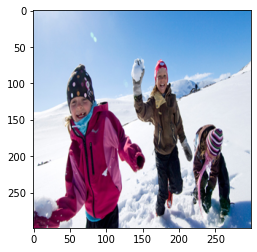

a man is skiing down a hill on a snowy hill .
a person on a snowboard in the snow .
a person on a snowboard on a snowy slope .
a man is riding a skateboard down a snowy hill .
a person on a snowboard on a snowy hill
a man on a skateboard in the snow .
a person on a snowboard on a snowy slope .
--2022-06-19 18:46:49--  https://cdn7.dissolve.com/p/D943_94_311/D943_94_311_1200.jpg
Resolving cdn7.dissolve.com (cdn7.dissolve.com)... 13.225.103.101, 13.225.103.87, 13.225.103.60, ...
Connecting to cdn7.dissolve.com (cdn7.dissolve.com)|13.225.103.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139829 (137K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>] 136.55K  --.-KB/s    in 0.03s   

2022-06-19 18:46:49 (4.52 MB/s) - ‘img_data/img.jpg’ saved [139829/139829]



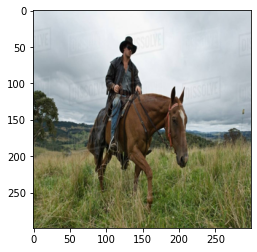

a man with a horse and a horse .
a man is sitting on a horse in a field .
a man with a horse and a black horse .
a man riding a horse in the grass .
a man with a horse and a horse .
a man in a black hat and a horse .
a man is sitting on a horse in a field .
--2022-06-19 18:46:53--  https://img.freepik.com/free-photo/a-giraffe-group-eats-the-leaves-of-the-acacia-trees_258981-631.jpg
Resolving img.freepik.com (img.freepik.com)... 104.93.1.225, 2600:1417:76:48b::30ec, 2600:1417:76:49e::30ec
Connecting to img.freepik.com (img.freepik.com)|104.93.1.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92811 (91K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  90.64K  --.-KB/s    in 0.008s  

2022-06-19 18:46:53 (11.7 MB/s) - ‘img_data/img.jpg’ saved [92811/92811]



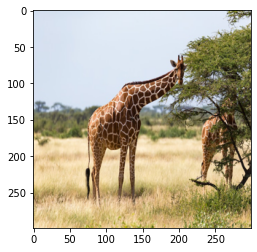

a giraffe standing in a field with a tree .
a giraffe standing in a field with trees in the background .
a giraffe standing in the grass next to a tree .
a giraffe standing in a field with a tree in the background .
a giraffe standing in the grass next to a tree .
a giraffe standing in a field with trees in the background .
a giraffe standing in the grass next to a tree .
--2022-06-19 18:46:57--  https://image.shutterstock.com/image-photo/cow-standing-lake-drinking-water-260nw-110403227.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 13.224.167.123, 13.224.167.95, 13.224.167.28, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|13.224.167.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37309 (36K) [image/jpeg]
Saving to: ‘img_data/img.jpg’

img_data/img.jpg    100%[===================>]  36.43K  --.-KB/s    in 0.003s  

2022-06-19 18:46:58 (12.3 MB/s) - ‘img_data/img.jpg’ saved [37309/37309]



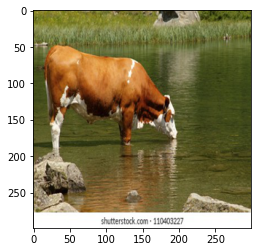

a cow is standing in the grass next to a tree .
a cow standing in the grass with a large tree .
a cow standing in the grass with a large tree .
a cow standing in the grass with a large tree .
a cow standing in the grass with a large tree .
a cow standing in the grass in the grass .
a cow standing next to a large tree .


In [115]:
def generate_caption_for_img(url, t = 7):
    !wget $url -O img_data/img.jpg
    img = plt.imread('img_data/img.jpg')
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(t):
        print(' '.join(generate_caption(img, t=t)[1:-1]))


for img_url in urls:
    generate_caption_for_img(img_url)